In [1]:
from glob import glob
import pandas as pd
import os
from tqdm import tqdm as tqdm 
from IPython.display import Image
from pathlib import Path
# import imageio
# import moviepy.video.io.ImageSequenceClip
from tqdm import tqdm
import math
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import json
import scipy.stats
import time
from types import SimpleNamespace
import random
import pandas as pd
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
os.environ["ROOT_DIR_BRAINTREEBANK"] = '/om2/user/zaho/braintreebank/braintreebank/'

In [3]:
from neuroprobe.config import NEUROPROBE_TASKS_MAPPING as task_name_mapping
import neuroprobe.config as neuroprobe_config
task_order = list(task_name_mapping.keys())

# Load single electrode results

In [4]:
import numpy as np
results_root = "data/single_electrode_eval_results_SS_DM/linear_stft_abs_nperseg512_poverlap0.75_maxfreq150_single_electrode/"
# results_root = "data/single_electrode_eval_results_SS_DM/linear_voltage_single_electrode/"

def get_test_results(results, eval_name):
    eval_results = results["evaluation_results"]
    assert len(eval_results.keys()) == 1
    records = []
    for subject_trial in eval_results:
        subject = subject_trial.split("_")[0][len("btbank"):]
        trial = subject_trial.split("_")[1]
        subject_trial_results = eval_results[subject_trial]['electrode']
        for electrode in subject_trial_results:
            electrode_results = subject_trial_results[electrode]
            time_bin_results = electrode_results["time_bins"]
            for time_bin in time_bin_results:
                time_bin_start = time_bin['time_bin_start']
                fold_results = time_bin['folds']
                avg_test = np.mean([f['test_roc_auc'] for f in fold_results])
                records.append({
                    "subject": subject,
                    "trial": trial,
                    "ID": f'{electrode}-sub_{subject}',
                    "electrode": electrode,
                    "avg_test": avg_test,
                    "time_bin": time_bin_start,
                    "task": eval_name
                })
        return records

all_records = []
all_results_paths = glob(os.path.join(results_root, "*"))
for path in tqdm(all_results_paths):
    name = Path(path).stem
    sub_id = name.split("_")[1][len("btbank"):]
    trial_id = name.split("_")[2]
    eval_name = "_".join(name.split("_")[3:])
    with open(path, "r") as f:
        results = json.load(f)
        test_results = get_test_results(results, eval_name)
    all_records += test_results
results_df = pd.DataFrame.from_records(all_records)

  1%|▊                                                                                                                                  | 2/300 [00:00<00:18, 16.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.88it/s]


# Plot brains

In [5]:
matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

save_dir = 'analyses/time_space_decoding_analysis/'
base_path = os.path.join(neuroprobe_config.ROOT_DIR, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# # Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

# scaled_coords_df[]
scaled_coords_df["ID"] = scaled_coords_df.Electrode + "-" + scaled_coords_df.Subject
spatial_avg_results_df = results_df.groupby(['task','ID']).max(['avg_test'])

In [6]:
spatial_avg_results_df = results_df.groupby(['task','ID']).mean(['avg_test'])
max_avg_test_perf = spatial_avg_results_df['avg_test'].values.max()


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.2, 'grey'), (0.4, 'yellow'), (1.0, 'red')])
grey_to_viridis = LinearSegmentedColormap.from_list('grey_to_viridis', [(0.0, 'grey'), (0.1, 'grey'), (1.0, '#fde725')])

lower = 0.500
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))
inverse_scale = lambda x: np.exp(x) + lower

In [32]:
import seaborn as sns
def plot_electrodes(plot_df, ax=None, hemisphere="left", title=None, vmin=None, vmax=None, min_size=0, max_size=40, rasterized=False):
    plot_df = plot_df.dropna() #TODO NOTE
    plot_df = plot_df.sort_values(by='avg_test', ascending=True)

    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==1]
    elif hemisphere=="right":
        ax.imshow(right_hem_img, alpha=0.7)
        plot_df = plot_df[plot_df.Hemisphere==0]


    ax.axis('off')
    assert hemisphere in ["left", "right"]


    plot_title = f'{hemisphere} hemisphere'

    if title:
        plot_title += f' {title}'

    all_x = plot_df['X']
    all_y = plot_df['Y']
    color = plot_df['avg_test']

    assert(list(sorted(color))==list(color))
    
    # Scale dot sizes based on color values - smaller for darker/grayer values
    scaled_color = np.maximum(color, 0.5).apply(scale)

    size_range = max_size - min_size
    sizes = min_size + size_range * np.minimum(1, (scaled_color - scale(0.50)) / (scale(0.7) - scale(0.50)))
    
    if vmin is None:
        vmin = scale(0.505)
    if vmax is None:
        vmax = scale(max_avg_test_perf)
    sc = ax.scatter(all_x, all_y,   
                s=sizes,
                linewidths=1,
                c=color.apply(scale),
                edgecolors="black",
                clip_on=False,
                # cmap="viridis",
                cmap=grey_to_red,
                vmin=vmin,
                vmax=vmax,
                rasterized=rasterized,
                   )
    return sc

/tmp/ipykernel_3041603/4277858287.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


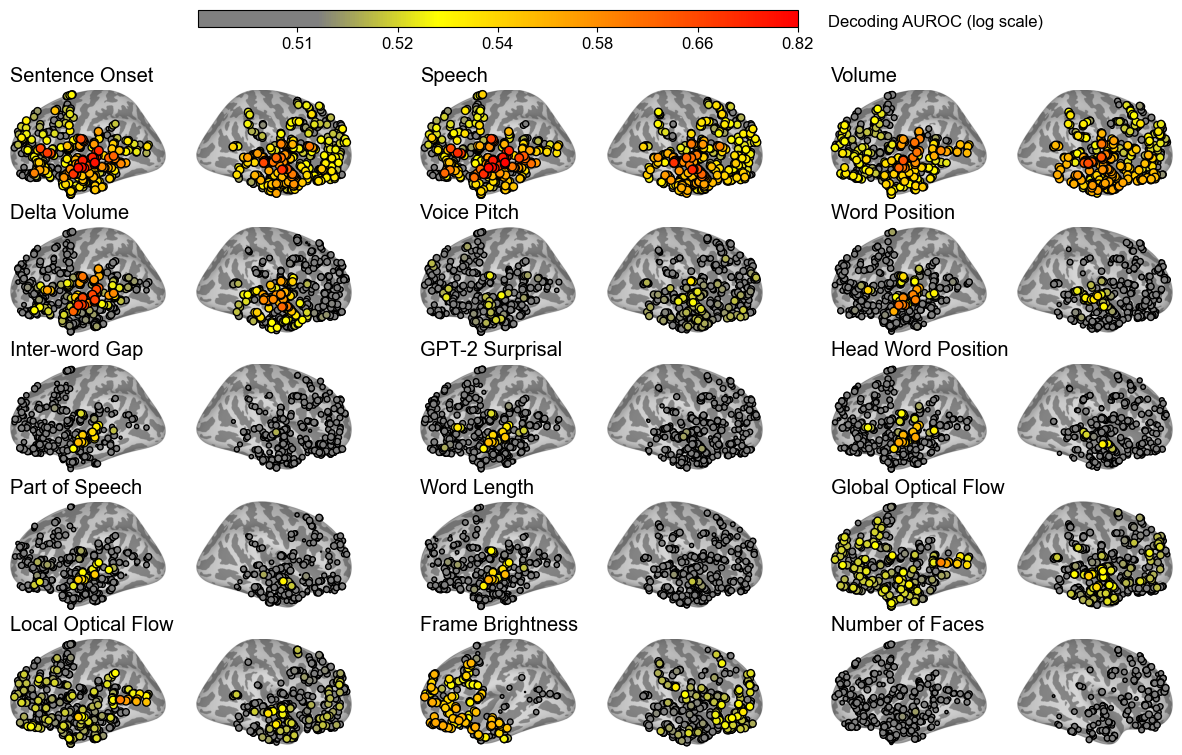

In [9]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.colorbar import ColorbarBase

fig = plt.figure(figsize=(15, 8.4))

# Add Arial font
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

num_cols = 3
num_rows = 5

# Create main grid for plots
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.2, top=0.9)

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # Skip the last few cells since we only have tasks to fill
        if i*num_cols+j >= len(task_order):
            continue
            
        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, subplot_spec=outer[outer_idx], hspace=0.1
        )
            
        for k in range(2):
            ax = fig.add_subplot(inner[k])
            task = task_order[i*num_cols+j]
            task_df = spatial_avg_results_df.loc[task].copy()

            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task, vmax=scale(0.82))
            
            if k == 0:
                ax.set_title(task_name_mapping[task], loc='left')
# Add colorbar at the top of the figure
cbar_ax = fig.add_axes([0.25, 0.97, 0.4, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
# Set custom tick positions
custom_ticks = [0.51, 0.52, 0.54, 0.58, 0.66, 0.82]
cbar.set_ticks([scale(tick) for tick in custom_ticks])
cbar.ax.tick_params()
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
# Add label to the right of the colorbar
fig.text(0.67, 0.975, "Decoding AUROC (log scale)", ha='left', va='center')

plt.tight_layout()
plt.savefig('analyses/time_space_decoding_analysis/space_decoding_analysis.pdf', bbox_inches='tight')

/tmp/ipykernel_3041603/1963796846.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


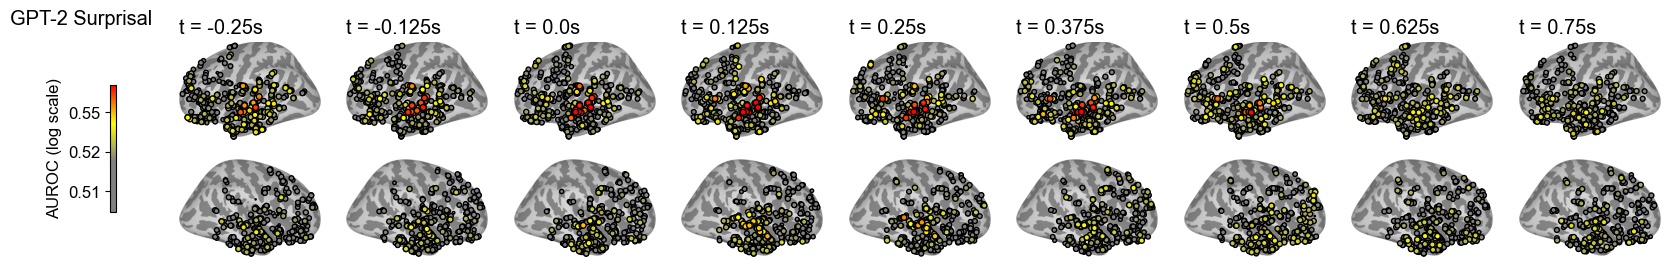

In [10]:
task = "gpt2_surprisal"


grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.4, 'grey'), (0.7, 'yellow'), (1.0, 'red')])
grey_to_viridis = LinearSegmentedColormap.from_list('grey_to_viridis', [(0.0, 'grey'), (0.1, 'grey'), (1.0, '#fde725')])

lower = 0.501
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))
inverse_scale = lambda x: np.exp(x) + lower

times = list(np.arange(-0.5, 1.25, 0.125))
fig = plt.figure(figsize=(20, 3))
selected_times = times[1:-3]
num_cols = len(selected_times)
num_rows = 1

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.0, width_ratios = [0.3] + [1]*(num_cols-1))

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(1, num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[outer_idx], hspace=0.05
        )

        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            time = selected_times[j]
            task_df = results_df[results_df.time_bin==time].groupby(['task','ID']).max(['avg_test']).loc[task].copy()

            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task, vmax=scale(0.6), min_size=0, max_size=20)
            
            if k == 0:
                ax.set_title(f"t = {time}s", loc='left')

ax = fig.add_subplot(outer[0])
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', location='left')
cbar.ax.tick_params()
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
cbar.set_label("AUROC (log scale)")
ax.set_axis_off()
plt.tight_layout()
plt.title(task_name_mapping[task], loc="right")
plt.show()

/tmp/ipykernel_3041603/655978123.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


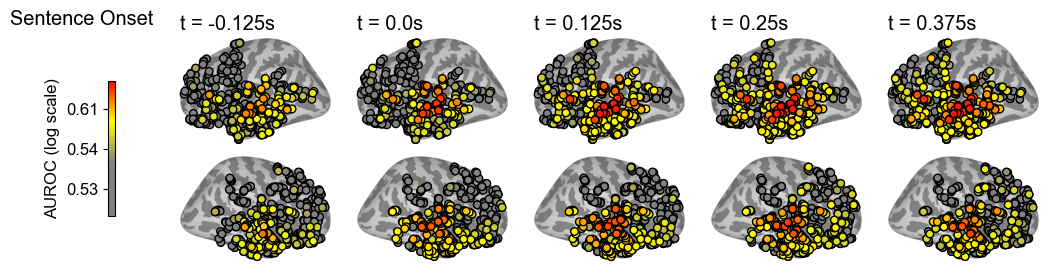

In [18]:
task = "onset"


grey_to_red = LinearSegmentedColormap.from_list('grey_to_red', [(0.0, 'grey'), (0.4, 'grey'), (0.7, 'yellow'), (1.0, 'red')])
grey_to_viridis = LinearSegmentedColormap.from_list('grey_to_viridis', [(0.0, 'grey'), (0.1, 'grey'), (1.0, '#fde725')])

lower = 0.53
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))
inverse_scale = lambda x: np.exp(x) + lower

times = list(np.arange(-0.5, 1.25, 0.125))
fig = plt.figure(figsize=(12, 3))
selected_times = times[2:-6:1]
num_cols = len(selected_times)
num_rows = 1

outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.2, hspace=0.0, width_ratios = [0.3] + [1]*(num_cols-1))

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(1, num_cols):
        # Index in outer grid
        outer_idx = i * num_cols + j

        # Define inner 2x1 grid within this cell
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[outer_idx], hspace=0.05
        )

        for k in range(2):
            ax = fig.add_subplot(inner[k])
#             print(i*4+j)
            time = selected_times[j]
            task_df = results_df[results_df.time_bin==time].groupby(['task','ID']).max(['avg_test']).loc[task].copy()

            merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
            hem = ["left","right"][k]
            sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task, vmax=scale(1.0), min_size=30, max_size=30)
            
            if k == 0:
                ax.set_title(f"t = {time}s", loc='left')

ax = fig.add_subplot(outer[0])
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', location='left')
cbar.ax.tick_params()
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
cbar.set_label("AUROC (log scale)")
ax.set_axis_off()
plt.tight_layout()
plt.title(task_name_mapping[task], loc="right")
plt.savefig(f'analyses/time_space_decoding_analysis/time_decoding_analysis_{task}.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3041603/25156176.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


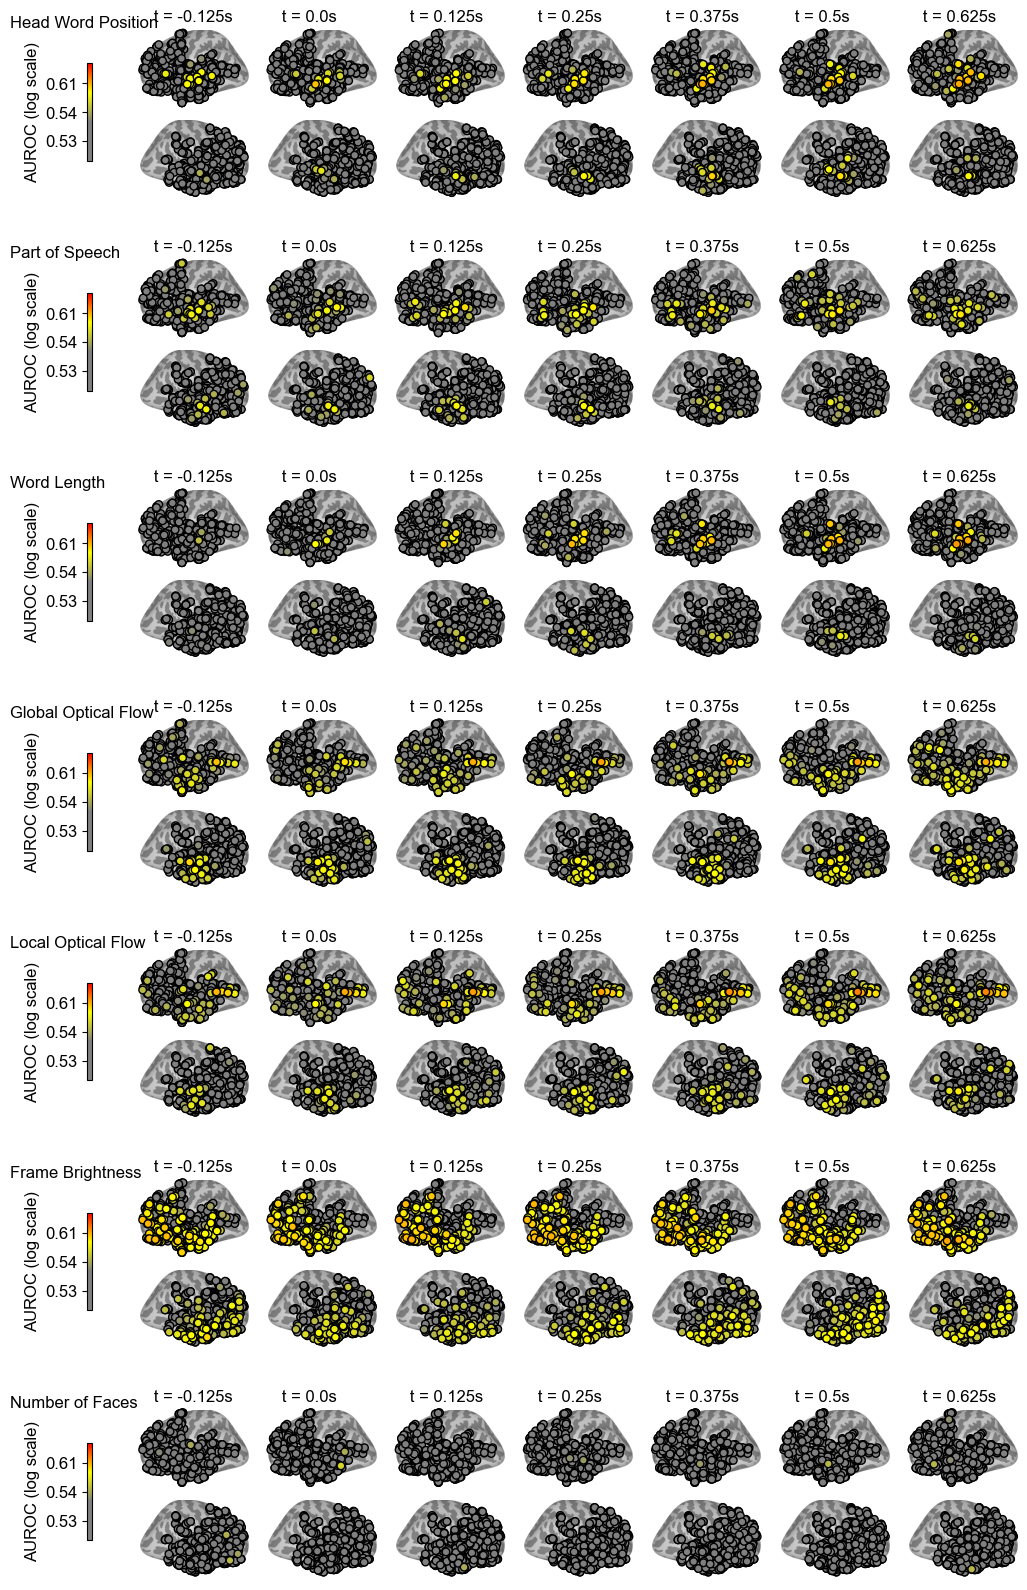

In [38]:
# for task in 
from matplotlib.gridspec import GridSpec

num_tasks = 8
start_task = 8

fig = plt.figure(figsize=(12, 2.9*num_tasks))
times = list(np.arange(-0.5, 1.25, 0.125))
selected_times = times[2:-4:1]
num_cols = len(selected_times)
num_rows = 1

gs_master = GridSpec(num_tasks, 1, figure=fig, hspace=0.3)

for task_i, task in enumerate(task_order[start_task:start_task+num_tasks]):
    outer = gs_master[task_i].subgridspec(num_rows, num_cols, wspace=0.2, hspace=0.0, width_ratios = [0.3] + [1]*(num_cols-1))

    # Loop through each subplot and add a simple plot or title
    for i in range(num_rows):
        for j in range(1, num_cols):
            # Index in outer grid
            outer_idx = i * num_cols + j

            # Define inner 2x1 grid within this cell
            inner = gridspec.GridSpecFromSubplotSpec(
                2, 1, subplot_spec=outer[outer_idx], hspace=0.05
            )

            for k in range(2):
                ax = fig.add_subplot(inner[k])
                time = selected_times[j]
                task_df = results_df[results_df.time_bin==time].groupby(['task','ID']).max(['avg_test']).loc[task].copy()

                merged_df = pd.merge(scaled_coords_df, task_df, on="ID", how="left")
                hem = ["left","right"][k]
                sc = plot_electrodes(merged_df, hemisphere=hem, ax=ax, title=task, vmax=scale(1.0), min_size=30, max_size=30, rasterized=True)
                
                if k == 0:
                    ax.set_title(f"   t = {time}s", loc='left', fontsize=12)

    ax = fig.add_subplot(outer[0])
    cbar = fig.colorbar(sc, ax=ax, orientation='vertical', location='left')
    cbar.ax.tick_params()
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val):.02}"))
    cbar.set_label("AUROC (log scale)")
    ax.set_axis_off()
    ax.text(-3.5, 1.0, task_name_mapping[task], transform=ax.transAxes, ha='left', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
# plt.savefig(f'analyses/time_space_decoding_analysis/time_decoding_analysis_manytasks_from{start_task}_to{start_task+num_tasks}.pdf', bbox_inches='tight', dpi=300) # takes too much space
plt.savefig(f'analyses/time_space_decoding_analysis/time_decoding_analysis_manytasks_from{start_task}_to{start_task+num_tasks}.jpg', bbox_inches='tight', dpi=200)


# Plotting decodability over time

/tmp/ipykernel_3041603/22921920.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


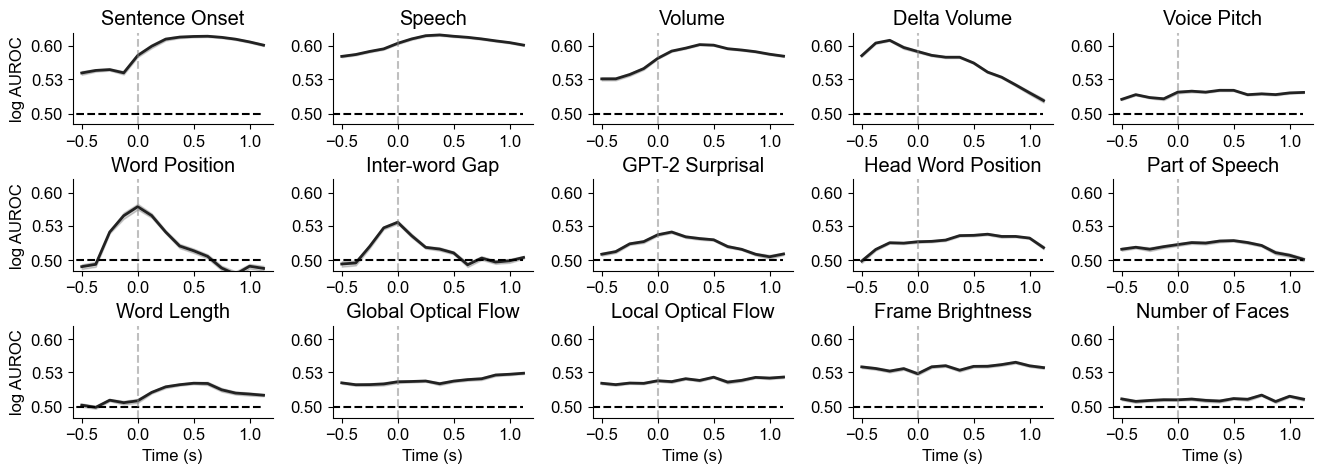

In [12]:
fig = plt.figure(figsize=(16, 5))

num_cols = 5
num_rows = 3
outer = gridspec.GridSpec(num_rows, num_cols, wspace=0.3, hspace=0.6)

upper = 0.68
lower = 0.48
epsilon = 1e-4
scale = lambda x: (np.log(max((x - lower), epsilon)))

# Loop through each subplot and add a simple plot or title
for i in range(num_rows):
    for j in range(num_cols):
        # i,j = 0,2 #TODO
        # Index in outer grid
        outer_idx = i * num_cols + j

        ax = fig.add_subplot(outer[outer_idx])
        task = task_order[i*num_cols+j]

        task_df = results_df[results_df.task==task].groupby("ID").mean(["avg_test"])
#         good_elecs = task_df[task_df.avg_test>0.5].index   
        
        good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
        time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
        # time_df.loc[:,'avg_test'] = [(100*x) for x in time_df['avg_test']]

        # scale = lambda x: (x - lower)
        # scale = lambda x: x
        time_df.loc[:,'avg_test'] = time_df['avg_test'].apply(scale)
        
#         time_df = results_df[(results_df.task==task)]

        # sns.set(style="whitegrid")

        # Create lineplot
        g = sns.lineplot(data=time_df, x="time_bin", y="avg_test", color="#222222", errorbar="se", linewidth=2)
        # plt.axis("off")  # disables the entire axis (spines, ticks, labels, etc.)
        plt.grid(False)  # ensures grid lines are also off
        ax.set_title(task_name_mapping[task])
        sns.despine() 
        # plt.yscale('log')
        plt.ylim(scale(0.495), scale(0.65))
        if j==0:
            ax.set_ylabel("log AUROC")
        else:
            ax.set_ylabel("")

        if i==num_rows-1:
            ax.set_xlabel("Time (s)")
        else:
            ax.set_xlabel("")

        ax.tick_params(axis='both', which='major')
        # ax.tick_params(axis='both', which='minor', labelsize=8)
        # plt.ylim(scale(1),scale(upper-lower))
        # for axes in g.axes:
        # ax.set_ylabel("ROC-AUC")
        #plt.ticklabel_format(axis='y', style='plain')             # <---- error
        ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{inverse_scale(val)}"))

        ax.set_yticks([scale(x) for x in [0.5, 0.53, 0.6]])

        ax.set_yticklabels(["0.50", "0.53", "0.60"])

        ax.set_xticks([-0.5, 0, 0.5, 1])

        plt.axhline(y=scale(0.5), xmin=-0.5, xmax=0.95, color="black", ls="--", label="Chance")
        plt.axvline(x=0, color="gray", ls="--", alpha=0.5)

        if i*num_cols+j >= 18:
            plt.legend(loc="lower right", bbox_to_anchor=(1.75, 0))
# from matplotlib.ticker import ScalarFormatter
# plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
# plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
        
        # from matplotlib.ticker import ScalarFormatter
        # plt.gca().yaxis.set_major_formatter(ScalarFormatter()) 
        # plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
        # if 
        # break
    # break
plt.tight_layout()
plt.savefig(f'analyses/time_space_decoding_analysis/time_decoding_analysis.pdf', bbox_inches='tight')
plt.show()

In [13]:
records = []
for task in task_order:
    good_elecs = results_df[results_df.task==task].groupby("ID").mean(["avg_test"]).sort_values(by="avg_test").dropna()[-100:].index  
    time_df = results_df[(results_df.task==task) & (results_df.ID.isin(good_elecs))]
    
    time_df = time_df.groupby("time_bin").mean("avg_test")
    time_df['time_bin'] = time_df.index
    # time_df
    time = time_df.sort_values(by="avg_test").reset_index(drop=True).iloc[-1]["time_bin"]
    records.append({"time_bin": time,
                    "task": task_name_mapping[task]})
argmax_time = pd.DataFrame.from_records(records)
argmax_time = argmax_time.sort_values(by="time_bin")
argmax_time.reset_index(drop=True)

,time_bin,task
0,-0.250,Delta Volume
1,0.000,Word Position
2,0.000,Inter-word Gap
3,0.125,Voice Pitch
4,0.125,GPT-2 Surprisal
5,0.375,Volume
6,0.375,Sentence Onset
7,0.375,Speech
8,0.375,Part of Speech
9,0.625,Head Word Position


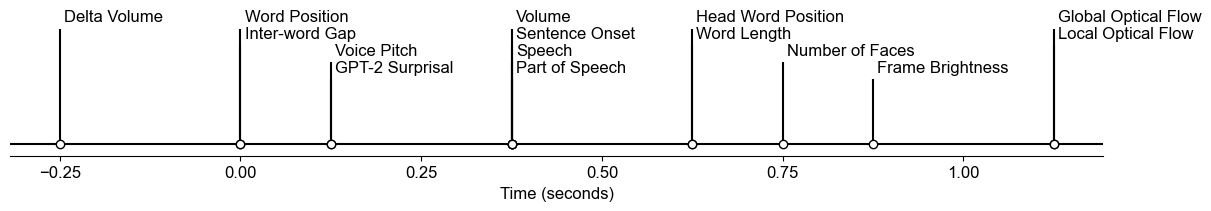

In [14]:
dates = list(argmax_time.time_bin)
releases = list(argmax_time.task)

# Choose some nice levels: alternate meso releases between top and bottom, and
# progressively shorten the stems for micro releases.
levels = []
for i in range(len(releases)):
    release = releases[i]
    date = dates[i]
    h = 1 + 0.8 * (9)
    # print(date)
    if i>0 and (date-dates[i-1])<=0.125:
    # left_nbr = 
        # print("trig")
        h = levels[i-1] - 1.2
    # else:
        # print("no trig")
    level = h 
    levels.append(level)


def is_feature(release):
    """Return whether a version (split into components) is a feature release."""
    return release[-1] == '0'


# The figure and the axes.
fig, ax = plt.subplots(figsize=(12, 2), layout="constrained")
# ax.set(title="Location of decodability peak")

# The vertical stems.
ax.vlines(dates, 0, levels,
          color=[("black", 1) for release in releases])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline.
micro_dates = [date for date, release in zip(dates, releases)
               if not is_feature(release)]
ax.plot(micro_dates, np.zeros_like(micro_dates), "ko", mfc="white")

# Annotate the lines.
for date, level, release in zip(dates, levels, releases):
    version_str = release
    ax.annotate(version_str, xy=(date, level),
                xytext=(3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom",
                weight="bold" if is_feature(release) else "normal",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

# ax.xaxis.set(major_locator=mdates.YearLocator(),
             # major_formatter=mdates.DateFormatter("%Y"))

ax.set_xticks(np.arange(-0.25, 1.25, 0.25))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xlabel("Time (seconds)")
ax.margins(y=0.1)
plt.savefig(f'analyses/time_space_decoding_analysis/time_decoding_analysis_argmax_time.pdf', bbox_inches='tight')
plt.show()